In [1]:
import re
import numpy as np
import pandas as pd
import json
import pickle
import string
import nltk
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer

In [2]:
review_df = pd.read_pickle("yelp_academic_dataset_review.pkl")
business_df = pd.read_pickle("yelp_academic_dataset_business.pkl")

In [3]:
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [4]:
review_df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [5]:
review_df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [6]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [7]:
df_merged = review_df.merge(business_df, left_on='business_id', right_on='business_id', how='inner', suffixes=('_review', '_business'))

In [8]:
df_merged.shape

(6990280, 22)

In [9]:
df_merged_state = df_merged.groupby(['state'])['review_id'].nunique()

In [13]:
df_merged_state.sort_values()

state
XMS          5
MT           6
VT          10
VI          11
MI          11
UT          19
WA          19
NC          29
CO          31
HI          34
TX          35
SD          42
MA          44
IL       51832
DE       70302
AB      109436
ID      157572
NJ      260897
CA      348856
NV      430678
AZ      431708
IN      489752
MO      502385
TN      614388
LA      761673
FL     1161545
PA     1598960
Name: review_id, dtype: int64

In [10]:
review_il = df_merged[(df_merged['state']=='IL')]

In [14]:
review_il.shape

(51832, 22)

In [15]:
review_il.head()

,review_id,user_id,business_id,stars_review,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_business,review_count,is_open,attributes,categories,hours
30720,Ad91EzbAGRCR1SwkPfZJKg,LWTvg7RlyNLXIf482tXBPw,WCVFqK84i2H5EClSoow7ZA,5.0,0,0,0,"Traveling through in our RV, stopped over in G...",2016-07-21 17:41:18,Itty-Bitty,...,IL,62040,38.761132,-90.084759,4.5,33,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Burgers, American (Traditional), R...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
30721,vYJXkULTCNVcfX7V34NDNw,kTnqh6o9zPeiks3JVv-DyQ,WCVFqK84i2H5EClSoow7ZA,5.0,4,0,0,"Before starting our trip, boyfriend and I wer...",2016-07-15 02:21:25,Itty-Bitty,...,IL,62040,38.761132,-90.084759,4.5,33,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Burgers, American (Traditional), R...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
30722,fjNcdg1AWZH-ktGIqMpKQw,9TJa9ORBQ6wjz-BqDYc2XA,WCVFqK84i2H5EClSoow7ZA,4.0,0,0,0,This food place is near my work and the fellow...,2018-06-19 12:32:31,Itty-Bitty,...,IL,62040,38.761132,-90.084759,4.5,33,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Burgers, American (Traditional), R...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
30723,Rc_8HI1BijwocWuqZdcFYw,I4aEtgDc9NhEdy_xDEL1mQ,WCVFqK84i2H5EClSoow7ZA,5.0,1,0,0,"This place lives up to its name: itty bitty, b...",2017-09-22 14:16:40,Itty-Bitty,...,IL,62040,38.761132,-90.084759,4.5,33,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Burgers, American (Traditional), R...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
30724,4lorAGeXbUrf-lAeO1TF8g,26duDjXndAb04W94N2mO_Q,WCVFqK84i2H5EClSoow7ZA,5.0,2,0,1,I am not ashamed to admit that I'm addicted to...,2012-04-11 15:17:56,Itty-Bitty,...,IL,62040,38.761132,-90.084759,4.5,33,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Burgers, American (Traditional), R...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."


In [ ]:
# review_il.to_csv('Illinois_review.csv')

In [16]:
review_il = pd.read_csv('Illinois_review.csv')

In [17]:
review_il.business_id.nunique()

2145

In [18]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [19]:
review_il.columns

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars_review',
       'useful', 'funny', 'cool', 'text', 'date', 'name', 'address', 'city',
       'state', 'postal_code', 'latitude', 'longitude', 'stars_business',
       'review_count', 'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

In [20]:
# Convert to list
data = review_il.text.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['traveling', 'through', 'in', 'our', 'rv', 'stopped', 'over', 'in', 'granite', 'city', 'found', 'this', 'little', 'gem', 'of', 'cafe', 'upon', 'entering', 'the', 'staff', 'was', 'very', 'sweet', 'and', 'friendly', 'this', 'is', 'like', 'home', 'cooking', 'we', 'ate', 'here', 'twice', 'and', 'all', 'our', 'food', 'choices', 'were', 'fresh', 'delicious', 'and', 'like', 'we', 'would', 'fix', 'at', 'home', 'yum']]


In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['traveling', 'through', 'in', 'our', 'rv', 'stopped', 'over', 'in', 'granite_city', 'found', 'this', 'little', 'gem', 'of', 'cafe', 'upon_entering', 'the', 'staff', 'was', 'very', 'sweet', 'and', 'friendly', 'this', 'is', 'like', 'home', 'cooking', 'we', 'ate', 'here', 'twice', 'and', 'all', 'our', 'food', 'choices', 'were', 'fresh', 'delicious', 'and', 'like', 'we', 'would', 'fix', 'at', 'home', 'yum']


In [22]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['travel', 'stop', 'granite_city', 'find', 'little', 'gem', 'cafe', 'upon_entere', 'staff', 'sweet', 'friendly', 'home', 'cooking', 'eat', 'twice', 'food', 'choice', 'fresh', 'delicious', 'fix', 'home', 'yum']]


In [24]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]


In [25]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('cafe', 1),
  ('choice', 1),
  ('cooking', 1),
  ('delicious', 1),
  ('eat', 1),
  ('find', 1),
  ('fix', 1),
  ('food', 1),
  ('fresh', 1),
  ('friendly', 1),
  ('gem', 1),
  ('granite_city', 1),
  ('home', 2),
  ('little', 1),
  ('staff', 1),
  ('stop', 1),
  ('sweet', 1),
  ('travel', 1),
  ('twice', 1),
  ('upon_entere', 1),
  ('yum', 1)]]

In [26]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [27]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.361*"customer" + 0.139*"issue" + 0.132*"fix" + 0.103*"absolutely" + '
  '0.060*"online" + 0.049*"seriously" + 0.026*"promise" + '
  '0.020*"unprofessional" + 0.018*"disgusting" + 0.013*"lovely"'),
 (1,
  '0.103*"staff" + 0.096*"friendly" + 0.069*"ever" + 0.056*"amazing" + '
  '0.047*"family" + 0.036*"owner" + 0.030*"month" + 0.029*"several" + '
  '0.028*"thank" + 0.027*"rude"'),
 (2,
  '0.134*"wrong" + 0.111*"awesome" + 0.102*"steak" + 0.077*"decent" + '
  '0.067*"twice" + 0.062*"worker" + 0.040*"chair" + 0.034*"dine" + '
  '0.029*"locate" + 0.022*"yummy"'),
 (3,
  '0.171*"selection" + 0.165*"beer" + 0.112*"fantastic" + 0.068*"glass" + '
  '0.064*"season" + 0.062*"space" + 0.056*"wine" + 0.053*"dessert" + '
  '0.030*"die" + 0.024*"heart"'),
 (4,
  '0.362*"salad" + 0.177*"item" + 0.097*"miss" + 0.086*"soup" + '
  '0.078*"beautiful" + 0.033*"fruit" + 0.021*"healthy" + 0.019*"grease" + '
  '0.015*"brunch" + 0.006*"blah"'),
 (5,
  '0.134*"order" + 0.071*"come" + 0.055*"wait" + 0.

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.112201561979104

Coherence Score:  0.33834926293630047


In [29]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 0.33, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.7, 1, 0.1))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('/Users/dhruvmehtadm/Documents/Courses/IS_517/Final_Project/archive/lda_tuning_results.csv', index=False)
    pbar.close()

In [30]:
model_results_df = pd.read_csv('lda_tuning_results.csv')

In [31]:
model_results_df.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.435579
1,75% Corpus,2,0.01,0.31,0.435579
2,75% Corpus,2,0.01,0.61,0.435579
3,75% Corpus,2,0.01,0.91,0.419728
4,75% Corpus,2,0.01,symmetric,0.435579


<Axes: xlabel='Topics'>

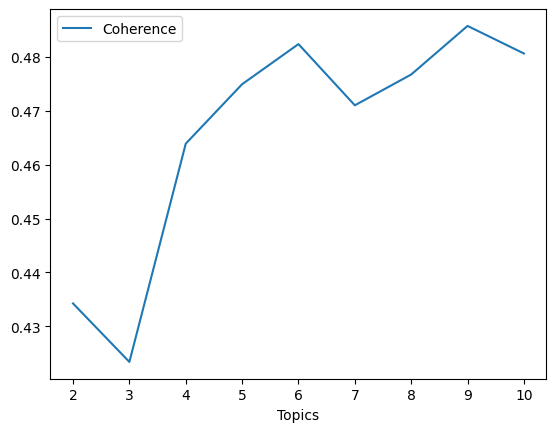

In [32]:
new_model_res = model_results_df.groupby(['Topics']).mean(['Coherence'])
new_model_res.plot()

- Topics: 6
- alpha = 0.31
- beta = 0.91

In [71]:
num_topics = 6

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.91)

In [72]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"get" + 0.023*"order" + 0.021*"go" + 0.018*"time" + 0.017*"food" + '
  '0.014*"wait" + 0.013*"say" + 0.013*"come" + 0.012*"take" + 0.011*"minute"'),
 (1,
  '0.036*"great" + 0.033*"good" + 0.030*"food" + 0.028*"place" + '
  '0.017*"service" + 0.015*"love" + 0.015*"go" + 0.014*"always" + '
  '0.013*"friendly" + 0.011*"time"'),
 (2,
  '0.014*"get" + 0.012*"go" + 0.012*"call" + 0.009*"tell" + 0.008*"take" + '
  '0.008*"car" + 0.008*"store" + 0.008*"time" + 0.008*"say" + 0.008*"make"'),
 (3,
  '0.022*"cake" + 0.014*"chocolate" + 0.013*"apple" + 0.013*"ice_cream" + '
  '0.012*"donut" + 0.011*"cupcake" + 0.009*"strawberry" + 0.008*"eckert" + '
  '0.007*"pie" + 0.007*"movie"'),
 (4,
  '0.020*"room" + 0.013*"coffee" + 0.010*"stay" + 0.009*"clean" + '
  '0.008*"place" + 0.007*"hotel" + 0.007*"area" + 0.006*"nice" + 0.006*"night" '
  '+ 0.005*"play"'),
 (5,
  '0.020*"good" + 0.017*"order" + 0.013*"chicken" + 0.013*"fry" + 0.012*"get" '
  '+ 0.011*"sauce" + 0.011*"salad" + 0.010*"che

In [73]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame(columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Get main topic in each document
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.loc[len(sent_topics_df)] = [int(topic_num), round(prop_topic,4), topic_keywords]
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(review_il.text)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [74]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.8643,"great, good, food, place, service, love, go, a...","Traveling through in our RV, stopped over in G..."
1,1,5,0.6755,"good, order, chicken, fry, get, sauce, salad, ...","Before starting our trip, boyfriend and I wer..."
2,2,1,0.8674,"great, good, food, place, service, love, go, a...",This food place is near my work and the fellow...
3,3,1,0.4449,"great, good, food, place, service, love, go, a...","This place lives up to its name: itty bitty, b..."
4,4,0,0.3952,"get, order, go, time, food, wait, say, come, t...",I am not ashamed to admit that I'm addicted to...
5,5,1,0.7170,"great, good, food, place, service, love, go, a...",Best burger in town. Fantastic little diner t...
6,6,1,0.5999,"great, good, food, place, service, love, go, a...",We looked at this place on Yelp but I wasn't s...
7,7,1,0.6654,"great, good, food, place, service, love, go, a...","Great portions for the price. Good food, good ..."
8,8,5,0.6849,"good, order, chicken, fry, get, sauce, salad, ...",This was the first time I ate here. It was so ...
9,9,1,0.6297,"great, good, food, place, service, love, go, a...","Great food,decent prices and awesome workers. ..."


In [75]:
df_dominant_topic.Dominant_Topic.unique()

array([1, 5, 0, 4, 2, 3])

In [76]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9893,"get, order, go, time, food, wait, say, come, t...",I am not gonna complain about the food or serv...
1,1,0.9687,"great, good, food, place, service, love, go, a...",Growing up in a small town and also living in ...
2,2,0.9947,"get, go, call, tell, take, car, store, time, s...","Frustrated\n\nOn a Friday afternoon, three day..."
3,3,0.9052,"cake, chocolate, apple, ice_cream, donut, cupc...","Gutes Deutsches Essen, nur leider war der süße..."
4,4,0.9725,"room, coffee, stay, clean, place, hotel, area,...","All I wanted in a gym is a swimming pool, and ..."


In [78]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,1,"great, good, food, place, service, love, go, a...",11063.0,0.2134
1,5,"good, order, chicken, fry, get, sauce, salad, ...",19349.0,0.3733
2,1,"great, good, food, place, service, love, go, a...",7766.0,0.1498
3,1,"great, good, food, place, service, love, go, a...",141.0,0.0027
4,0,"get, order, go, time, food, wait, say, come, t...",3255.0,0.0628
...,...,...,...,...
51827,5,"good, order, chicken, fry, get, sauce, salad, ...",NaN,NaN
51828,5,"good, order, chicken, fry, get, sauce, salad, ...",NaN,NaN
51829,5,"good, order, chicken, fry, get, sauce, salad, ...",NaN,NaN
51830,5,"good, order, chicken, fry, get, sauce, salad, ...",NaN,NaN


In [114]:
df_topic_sents_keywords['Dominant_Topic'].value_counts()

Dominant_Topic
1    19349
0    11063
5    10258
2     7766
4     3255
3      141
Name: count, dtype: int64

In [79]:
review_dominiant = df_dominant_topic.merge(review_il, left_on='Text', right_on='text')
review_dominiant.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Unnamed: 0,review_id,user_id,business_id,stars_review,...,state,postal_code,latitude,longitude,stars_business,review_count,is_open,attributes,categories,hours
0,0,1,0.8643,"great, good, food, place, service, love, go, a...","Traveling through in our RV, stopped over in G...",30720,Ad91EzbAGRCR1SwkPfZJKg,LWTvg7RlyNLXIf482tXBPw,WCVFqK84i2H5EClSoow7ZA,5.0,...,IL,62040,38.761132,-90.084759,4.5,33,0,"{'BusinessParking': ""{'garage': False, 'street...","Sandwiches, Burgers, American (Traditional), R...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,1,5,0.6755,"good, order, chicken, fry, get, sauce, salad, ...","Before starting our trip, boyfriend and I wer...",30721,vYJXkULTCNVcfX7V34NDNw,kTnqh6o9zPeiks3JVv-DyQ,WCVFqK84i2H5EClSoow7ZA,5.0,...,IL,62040,38.761132,-90.084759,4.5,33,0,"{'BusinessParking': ""{'garage': False, 'street...","Sandwiches, Burgers, American (Traditional), R...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
2,2,1,0.8674,"great, good, food, place, service, love, go, a...",This food place is near my work and the fellow...,30722,fjNcdg1AWZH-ktGIqMpKQw,9TJa9ORBQ6wjz-BqDYc2XA,WCVFqK84i2H5EClSoow7ZA,4.0,...,IL,62040,38.761132,-90.084759,4.5,33,0,"{'BusinessParking': ""{'garage': False, 'street...","Sandwiches, Burgers, American (Traditional), R...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
3,3,1,0.4449,"great, good, food, place, service, love, go, a...","This place lives up to its name: itty bitty, b...",30723,Rc_8HI1BijwocWuqZdcFYw,I4aEtgDc9NhEdy_xDEL1mQ,WCVFqK84i2H5EClSoow7ZA,5.0,...,IL,62040,38.761132,-90.084759,4.5,33,0,"{'BusinessParking': ""{'garage': False, 'street...","Sandwiches, Burgers, American (Traditional), R...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,4,0,0.3952,"get, order, go, time, food, wait, say, come, t...",I am not ashamed to admit that I'm addicted to...,30724,4lorAGeXbUrf-lAeO1TF8g,26duDjXndAb04W94N2mO_Q,WCVFqK84i2H5EClSoow7ZA,5.0,...,IL,62040,38.761132,-90.084759,4.5,33,0,"{'BusinessParking': ""{'garage': False, 'street...","Sandwiches, Burgers, American (Traditional), R...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."


In [80]:
review_dom = review_dominiant[['name', 'Dominant_Topic', 'review_id']]
review_dom_grpby = review_dom.groupby(['name', 'Dominant_Topic'])['review_id'].count().reset_index(name='count')
sorted_grouped = review_dom_grpby.sort_values(['name', 'count'], ascending=[True, False])

In [81]:
sorted_grouped

,name,Dominant_Topic,count
0,1 Nail Salon,0,13
1,1 Nail Salon,1,1
2,1 Nail Spa,0,8
3,1 Nail Spa,1,2
4,1 Nails,0,7
...,...,...,...
5076,friday's South Bar & Grill - Collinsville,1,20
5075,friday's South Bar & Grill - Collinsville,0,7
5077,friday's South Bar & Grill - Collinsville,5,6
5078,h h gregg,2,5


In [82]:
sorted_grouped['rank'] = sorted_grouped.groupby(['name'])['count'].rank(method='dense', ascending=False)
result = sorted_grouped[sorted_grouped['rank'] == 1][['name', 'Dominant_Topic', 'count']]
result

,name,Dominant_Topic,count
0,1 Nail Salon,0,13
2,1 Nail Spa,0,8
4,1 Nails,0,7
6,1 Spa and Nail,0,12
8,10th Street Baking,1,5
...,...,...,...
5068,Zapp Thai Noodle & Market,1,74
5074,bb.q Chicken - O'Fallon,5,31
5076,friday's South Bar & Grill - Collinsville,1,20
5078,h h gregg,2,5


In [83]:
result_1 = sent_topics_sorteddf_mallet.merge(result, left_on='Topic_Num', right_on='Dominant_Topic')

In [84]:
result_1.drop(['Topic_Perc_Contrib', 'Text', 'count', 'Topic_Num'], inplace=True, axis=1)

In [85]:
result_1.head()

,Keywords,name,Dominant_Topic
0,"get, order, go, time, food, wait, say, come, t...",1 Nail Salon,0
1,"get, order, go, time, food, wait, say, come, t...",1 Nail Spa,0
2,"get, order, go, time, food, wait, say, come, t...",1 Nails,0
3,"get, order, go, time, food, wait, say, come, t...",1 Spa and Nail,0
4,"get, order, go, time, food, wait, say, come, t...",A Q Nails & Spa,0


In [99]:
labels = pd.DataFrame({"Topic_number": [0,1,2,3,4,5], "Label": ["Poor Service", "Good Vibe", "Good Food & Service", "Dessert", "Hotel", "Soup"]})
labels

,Topic_number,Label
0,0,Poor Service
1,1,Good Vibe
2,2,Good Food & Service
3,3,Dessert
4,4,Hotel
5,5,Soup


In [102]:
result_with_labels = result_1.merge(labels, left_on='Dominant_Topic', right_on='Topic_number')
result_with_labels.drop(['Topic_number'], inplace=True, axis=1)
result_with_labels

,Keywords,name,Dominant_Topic,Label
0,"get, order, go, time, food, wait, say, come, t...",1 Nail Salon,0,Poor Service
1,"get, order, go, time, food, wait, say, come, t...",1 Nail Spa,0,Poor Service
2,"get, order, go, time, food, wait, say, come, t...",1 Nails,0,Poor Service
3,"get, order, go, time, food, wait, say, come, t...",1 Spa and Nail,0,Poor Service
4,"get, order, go, time, food, wait, say, come, t...",A Q Nails & Spa,0,Poor Service
...,...,...,...,...
1796,"good, order, chicken, fry, get, sauce, salad, ...",Wing China,5,Soup
1797,"good, order, chicken, fry, get, sauce, salad, ...",Wise Guys Gyros and Italian Beef,5,Soup
1798,"good, order, chicken, fry, get, sauce, salad, ...",Woody's Drive-In,5,Soup
1799,"good, order, chicken, fry, get, sauce, salad, ...",Young's Chop Suey,5,Soup


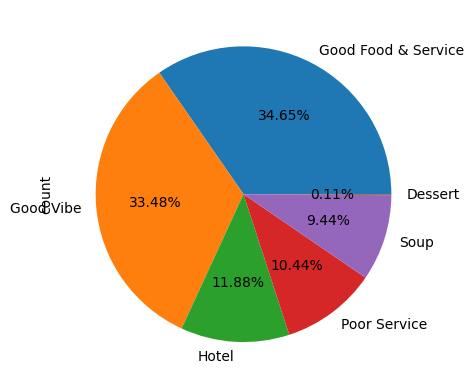

In [117]:
result_with_labels['Label'].value_counts().plot(kind = 'pie', autopct='%1.2f%%')
plt.show()